<a href="https://colab.research.google.com/github/146790g/VGG19-BreakHis/blob/master/BreakHis_VGG19_Model_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG19モデルを用いた乳がん染色画像（BreakHis）の解析

#（その１： Model Fitting）

##  Deep Learning for Magnification Independent Breast Cancer Histopathology
## Image Classification using VGG19 Model 

<h2>対象データは、こちらをクリック</>
<a href='https://www.kaggle.com/ambarish/breakhis'>Kaggle BreakHis Data</a>

４つのMagnification levelのデータをすべて合算して、解析する

<br>

## 4 Magnification Levels: ×40, ×100, ×200, ×400


During analysis and annotation, pathologists starts by identifying ROIs in
the lowest magnification level slide (×40), then dives deeper in the latter using higher magnification levels (×100, ×200) until having a profound insight
(×400). 

<br>

## データ数 の概要

・Training Data: 5026 images <br>
  -- Benign Data: 1472 images <br>
  -- Mallignant Data: 3554 images 

・Validation Data: 2904 images <br>
  -- Benign Data: 1008 images <br>
  -- Mallignant Data:1896 images <br>

## Data Set Details by Magnification levels.

 ×40 : <br>
×100 : <br>
×200 : <br>
×400 : <br>

In [ ]:
%tensorflow_version 2.x

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data'

total 8.0K
drwx------ 2 root root 4.0K Jul 21 03:42 train
drwx------ 2 root root 4.0K Jul 27 01:49 validation


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np


train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train' # Training Data のフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation' # Validation Data のフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'        # VGG19の出力結果を保存するフォルダー
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'
    


##第１章　VGG19モデルの構築


In [ ]:
 ## VGG19モデルと学習済み重みを読み込む



from keras.applications.vgg19 import VGG19

 ## VGG19モデルと学習済み重みを読み込む

 img_h, img_w = 400,400
channels = 3
batch_size = 30  


vgg19_model = VGG19(include_top=False,        # 全結合層は層（FC）は読み込まない
                    weights='imagenet',       # ImageNetで学習した重みを利用
                    input_shape=(img_h, img_w, channels) # 入力データの形状
                   )

# VGG16モデルのサマリを出力
print('VGG19モデルのサマリ')
vgg19_model.summary()

# VGG19のblock1_conv1からblock4_poolまでを凍結
# block5のみを学習可能にする
vgg19_model.trainable = True
set_trainable = False
for layer in vgg19_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:        
        layer.trainable = True
    else:
        layer.trainable = False
    
## 凍結後のサマリを出力
print('凍結後のサマリ')
vgg19_model.summary()

## VGG19モデルと独自のFC層を連結した計算モデルを構築
# Sequentialオブジェクトを生成
model = Sequential()

# VGG19モデルを追加
model.add(vgg19_model)
# Flatten層
model.add(Flatten())
# 全結合層
model.add(Dense(256,                 # ニューロン数は256
                activation='relu'    # 活性化関数はReLU
                ))
#出力層
model.add(Dense(1, activation='sigmoid', name='sigmoid'))

# VGG19に独自のFC層を結合したモデルのサマリを出力
print('結合後のサマリ')
model.summary()   
     
     
     
  

80142336/80134624 [==============================] - 1s 0us/step
VGG19モデルのサマリ
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________

In [ ]:
## モデルのコンパイル
# 最適化はRMSpropで行う
# 学習率を小さくしたのはファインチューニングを

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
%pwd

'/content'

##第２章　データ拡張

In [ ]:
img_h, img_w = 400,400
channels = 3
batch_size = 30               # ミニバッチのサイズ

#train_data_dir = 'content/data/train' # 訓練データのフォルダー
#validation_data_dir = 'content/data/validation' # テストデータのフォルダー
#result_dir = 'results'        # VGG16の出力結果を保存するフォルダー  


## 訓練データを読み込むジェネレーターを生成
# データ拡張を行う
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,     # 40度の範囲でランダムに回転させる
    width_shift_range=0.2,  # 横サイズの0.2の割合でランダムに水平移動
    height_shift_range=0.2, # 縦サイズの0.2の割合でランダムに垂直移動
    horizontal_flip=True,   # 水平方向にランダムに反転、左右の入れ替え
    vertical_flip=True,
    zoom_range=0.8,         # ランダムに拡大
    shear_range=0.2         # シアー変換をかける
)


# Dog vs Catの訓練データを生成するするジェネレーター
train_generator = train_datagen.flow_from_directory(
    train_data_dir,             # 訓練データのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)


## テストデータを読み込むジェネレーターを生成
test_datagen = ImageDataGenerator(rescale=1.0 / 255)


# Dog vs Catのテストデータを生成するするジェネレーター
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,        # テストデータのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)

Found 5026 images belonging to 2 classes.
Found 2904 images belonging to 2 classes.


In [ ]:
type(train_generator)
print(train_generator.class_indices)
print(validation_generator.class_indices)


{'benign': 0, 'malignant': 1}
{'benign': 0, 'malignant': 1}


## 第３章　Model Fitting

In [ ]:
epochs=50
num_train = 5026
num_validation = 2904

## 学習を行う

# 訓練データのジェネレーターのサイズ
print(len(train_generator))
# 訓練データの数をミニバッチのサイズで割った値
print(num_train//batch_size)
# テストデータのジェネレーターのサイズ
print(len(validation_generator))
# テストデータの数をミニバッチのサイズで割った値
print(num_validation//batch_size)

# モデルのファインチューニング
history = model.fit(
    
    # 訓練データのジェネレーター
    train_generator,
    # 各エポックにおけるステップ数として
    # 訓練データの数をミニバッチのサイズで割った値を指定
    steps_per_epoch=num_train//batch_size,
    # エポック数（学習回数）
    epochs=epochs,
    # テストデータのジェネレーター
    validation_data=validation_generator,
    # テストにおける各エポックにおけるステップ数として
    # テストデータの数をミニバッチのサイズで割った値を指定
    validation_steps=num_validation//batch_size
)

168
167
97
96
Epoch 1/50
167/167 [==============================] - 3319s 20s/step - loss: 0.5397 - accuracy: 0.7378 - val_loss: 0.6184 - val_accuracy: 0.6931
Epoch 2/50
167/167 [==============================] - 307s 2s/step - loss: 0.4451 - accuracy: 0.7878 - val_loss: 0.5141 - val_accuracy: 0.7569
Epoch 3/50
167/167 [==============================] - 297s 2s/step - loss: 0.4008 - accuracy: 0.8199 - val_loss: 0.4434 - val_accuracy: 0.8024
Epoch 4/50
167/167 [==============================] - 289s 2s/step - loss: 0.3577 - accuracy: 0.8465 - val_loss: 0.4083 - val_accuracy: 0.8295
Epoch 5/50
167/167 [==============================] - 291s 2s/step - loss: 0.3289 - accuracy: 0.8593 - val_loss: 0.5272 - val_accuracy: 0.8076
Epoch 6/50
167/167 [==============================] - 284s 2s/step - loss: 0.3301 - accuracy: 0.8667 - val_loss: 0.4217 - val_accuracy: 0.8295
Epoch 7/50
167/167 [==============================] - 282s 2s/step - loss: 0.3071 - accuracy: 0.8757 - val_loss: 0.4918 - val_

In [ ]:
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'  


with open(os.path.join(result_dir,'breakhis_vgg19model.json'),'w') as json_file:
  json_file.write(model.to_json())

#model parameter save
model.save_weights(os.path.join(result_dir,'breakhis_vgg19parameter.h5'))


# model save
model.save(os.path.join(result_dir,'breakhis_vgg19model_parameter.h5'))

import pandas as pd

df_history=pd.DataFrame(history.history)

df_history.to_pickle(os.path.join(result_dir,'historyvgg19.pkl'))

In [ ]:
type(history)
history.history
type(history.history)

dict

In [ ]:
np.mean(history.history['accuracy'][45:50])

0.9435948729515076

In [ ]:
np.mean(history.history['val_accuracy'][45:50])

0.8429861187934875

##【考察】
epochが、46番から50番までの精度の平均値を算出すると、  
訓練データ：精度：94.35 ％  
テストデータ：精度：84.30％  
であった。
 このことから、このVGG19モデルのファインチューニング法により構築されたモデルは、十分に妥当であると考えられる。

##第４章　モデルの評価

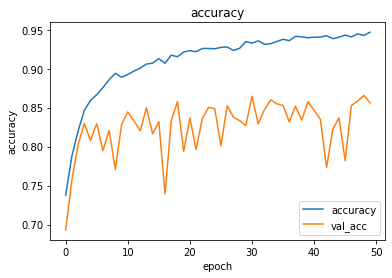

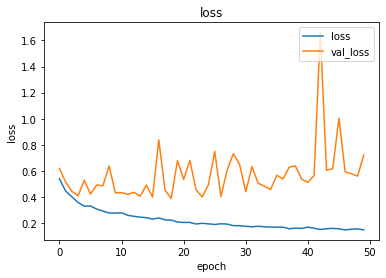

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)